# Compare the CH4 absorption coefficient used in Satellite Bands against the HITRAN database

HAPI version: 1.2.2.2
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

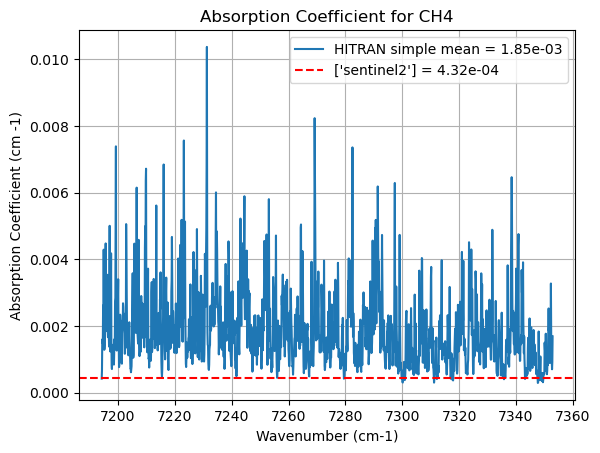

target wavenumbers 6042.296072507553 6389.776357827476
Using /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran

CH4
                     Lines parsed: 4954
CH4_sentinel2_11
                     Lines parsed: 5831
CH4_sentinel2_10
                     Lines parsed: 4954
CH4_sentinel2_12
                     Lines parsed: 24625

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/me

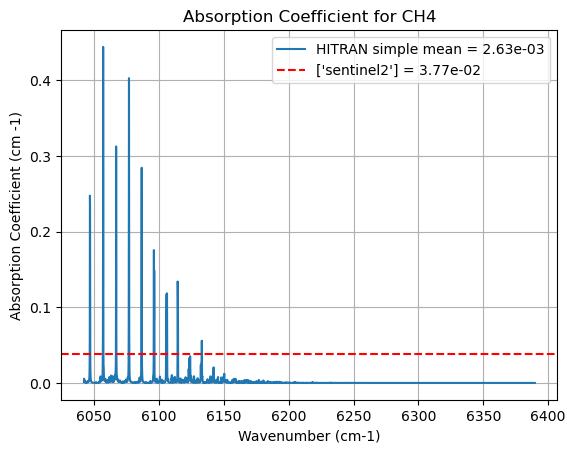

target wavenumbers 4385.964912280701 4761.9047619047615
Using /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran

CH4
                     Lines parsed: 5831
CH4_sentinel2_11
                     Lines parsed: 5831
CH4_sentinel2_10
                     Lines parsed: 4954
CH4_sentinel2_12
                     Lines parsed: 24625

Data is fetched from http://hitran.org

BEGIN DOWNLOAD: CH4
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran/CH4.data
  65536 bytes written to /Users/yunhalee/Documents/m

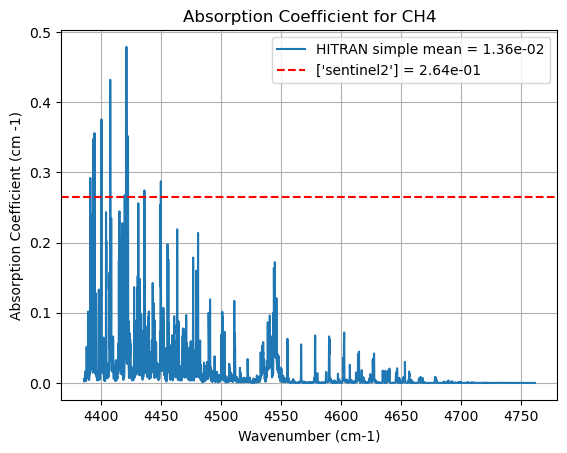

In [2]:
from hapi import *
import ssl
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set necessary for accessing HITRAN database 
os.environ['GLOBAL_HOST'] = 'http://hitran.org'
ssl._create_default_https_context = ssl._create_unverified_context

# file with satellite bands
satellites = ["sentinel2"]

for satellite in satellites: 
    obs_file = f"../input_data/{satellite}_band_wavelength.csv"

    bands = pd.read_csv(obs_file)
    print(bands)

    # subset the data based on CH4_AC > 0 
    subset_bands = bands[bands["CH4_AC"] < 0]
    subset_bands = subset_bands[["Wavelength_start", "Wavelength_end", "CH4_AC"]]

    print(subset_bands)

    for index, row in subset_bands.iterrows():
        wavelength_start = row["Wavelength_start"]
        wavelength_end = row["Wavelength_end"]
        ch4_ac = row["CH4_AC"]
    
        #Compute wavelength range and wavenumber in cm^-1
        low_wavenumbers = 1.e7 / wavelength_end
        high_wavenumbers = 1.e7 / wavelength_start

        print("target wavenumbers", low_wavenumbers, high_wavenumbers)

        # Set the local folder to download the HITRAN data
        db_begin('/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/input_data/hitran')
        fetch('CH4',6,1,low_wavenumbers,high_wavenumbers)
        describeTable('CH4')

        # HITRAN_units : cm^2/molec (if True) and cm-1 (if False) and  WavenumberStep default value is 0.01 cm-1 but changed to 1 for now
        nu,abs_coef = absorptionCoefficient_Lorentz(SourceTables='CH4', Diluent={'air':1.0}, HITRAN_units=False, Environment ={'T':296.,'p':1.}, WavenumberStep = 0.1)

        # Filter out zero values
        filtered_abs_coef = abs_coef[abs_coef > 0]

        # Compute effective absorption coefficient (This is smaller than simple averaging)
        if len(filtered_abs_coef) > 0:
            effective_abs_coef = np.exp(np.mean(np.log(filtered_abs_coef)))
        else:
            effective_abs_coef = 0  # or handle this case as needed

        print(len(abs_coef), abs_coef.mean(), effective_abs_coef, np.abs(ch4_ac))

        # Plot the absorption coefficient
        plt.plot(nu, abs_coef, label=f'HITRAN simple mean = {abs_coef.mean():.2e}')
        plt.axhline(y=np.abs(ch4_ac), color='r', linestyle='--', label=f'{satellites} = {np.abs(ch4_ac):.2e}')
        #plt.text(0.05, 0.95, f'Mean Absorption Coefficient: {abs_coef.mean():.2e}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        #plt.text(0.05, 0.90, f'|ch4_ac|: {np.abs(ch4_ac):.2e}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
        plt.xlabel('Wavenumber (cm-1)')
        plt.ylabel('Absorption Coefficient (cm -1)')
        plt.title('Absorption Coefficient for CH4')
        plt.legend()
        plt.grid(True)
        plt.show()

        # convert cm^2/mole to m2/kg, which is the concentration unit from the Gaussian Model. 
        ch4_molar_weight = 0.01604 # kg/mole 
        Avogadro = 6.022e23 # molecules per mole
        convert_unit = Avogadro/ch4_molar_weight/1e4 # cm2/mole to m2/kg
        abs_coef= abs_coef*convert_unit

# Rotate the methane plume concentration field to mimick the wind directions

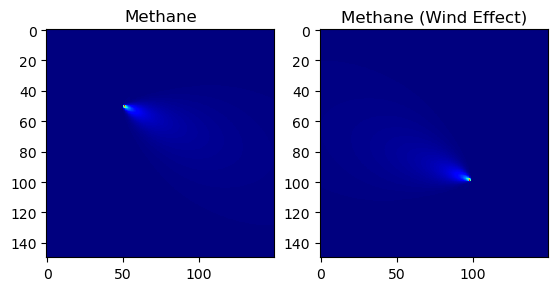

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


filename = "/Users/yunhalee/Documents/methanDart/Gaussian_Puff_CH4/output_data/gplume_conc/gplume_output_WS_1.5_stackH_30_stability_['B']_radiaton_weak_WD_20_spread_20.npy"
methane_data = np.load(filename)


def apply_wind_effect(methane_data, wind_direction):
    """
    Apply the wind direction effect to the methane image data.
    
    Parameters: 
    methane_data: 2D array of methane transmittance data
    wind_direction: Wind direction in degrees (0-360)

    Return: Rotated methane data to simulate wind direction change
    """
    # Rotate the methane data based on wind direction
    rotated_methane = rotate(methane_data, angle=-wind_direction, reshape=False, mode='nearest')
    return rotated_methane

# Simulate for a specific wind direction (e.g., 45 degrees)
wind_direction = 180
methane_with_wind = apply_wind_effect(methane_data, wind_direction)


# Display the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title("Methane")
plt.imshow(np.mean(methane_data, axis = -1).T, cmap='jet')

plt.subplot(1, 3, 2)
plt.title("Methane (Wind Effect)")
plt.imshow(np.mean(methane_with_wind, axis = -1).T, cmap='jet')


plt.show()

# read carbonmapper plume image to get the concentration range

Carbon mapper's concentration is ppm per meter. 


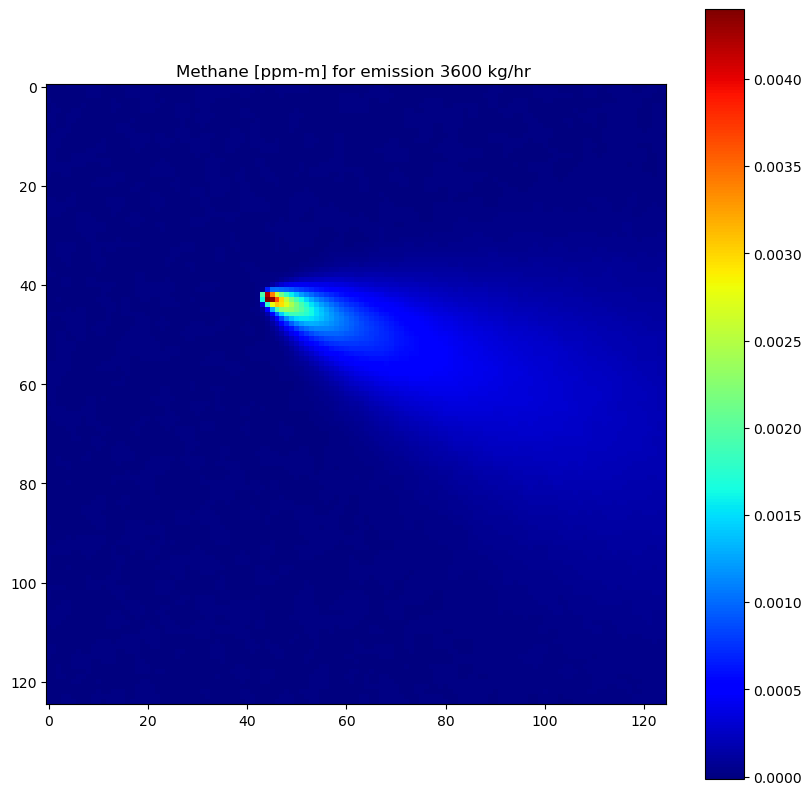

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate


filename = "/Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/output_data/gplume_conc/gplume_output_WS_6.5_stackH_30_stability_['D']_radiaton_weak_WD_20_spread_40.npy"
filename = "/Users/yunhalee/Documents/methanDart/Gaussian_CH4_Modeling/output_data/gplume_conc/gplume_output_WS_1.5_stackH_30_stability_['A']_radiaton_strong_WD_20_spread_10.npy"
methane_data = np.load(filename)

# Convert ug m-3 to ppm per meter
mean_ch4_concentration = np.mean(methane_data, axis=2)

# Constants
R = 8.314  # Ideal gas constant in J/(mol·K)
T = 298.15  # Standard temperature in K
P = 101325  # Standard pressure in Pa
M = 16.04  # Molar mass of CH4 in g/mol

total_grid_height = 2000 # meters 
ch4_ppm = (mean_ch4_concentration / 1e6) * R * T / (M * P) * 1e6
ch4_ppm = ch4_ppm / total_grid_height 


# Display the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 1, 1)
plt.title("Methane [ppm-m] for emission 3600 kg/hr ")
plt.imshow(ch4_ppm.T, cmap='jet')
plt.colorbar()

Warning 3: Cannot find header.dxf (GDAL_DATA is not defined)


DataArray info:
<xarray.DataArray (band: 4, y: 151, x: 151)> Size: 91kB
[91204 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
Dimensions without coordinates: y, x
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
('band', 'y', 'x')
Coordinates:
  * band         (band) int64 32B 1 2 3 4
    xc           (y, x) float64 182kB 3.607e+05 3.607e+05 ... 3.612e+05
    yc           (y, x) float64 182kB 3.799e+06 3.799e+06 ... 3.799e+06
    spatial_ref  int64 8B 0
{'AREA_OR_POINT': 'Area', 'scale_factor': 1.0, 'add_offset': 0.0}
CRS: EPSG:32611
Bounds: (360660.9674670138, 3798675.389420468, 361053.5674670138, 3799067.989420468)


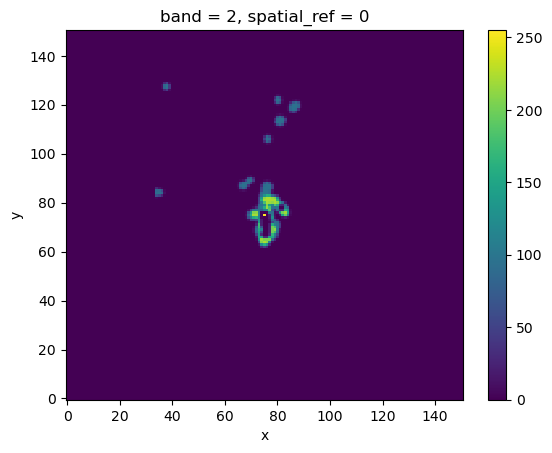

In [10]:
import xarray as xr
import rioxarray

# Path to the GeoTIFF file
file = "/Users/yunhalee/Documents/methanDart/carbonmapper/CarbonMapper_Aerial/carbonmapper_ch4_rgb_geotiffs_2020_2021/carbonmapper_ch4_rgb_geotiffs_2020_2021/ang20200708t192518-3_r1823_c108_ctr.tif"

# Open the GeoTIFF file as an xarray DataArray
data = rioxarray.open_rasterio(file)

# Display basic information about the data
print("DataArray info:")
print(data)

# Plotting the first band (or all bands if it's a multi-band image)
data.plot()

print(data.dims) 
print(data.coords)  
print(data.attrs) 

band1 = data.sel(band=2) 
band1.plot()  # Plot the first band

print("CRS:", data.rio.crs) 
print("Bounds:", data.rio.bounds()) 

## TODO - find out the unit of the data